In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# Inputs
# epsilons - list of epsilon values to use for the ran, epsilon <= 1

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda = True

In [11]:
# Model Under Attack
# define the model and dataloader, then initialize and load pretrained weights

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)   # why this
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# MNIST test dataset and dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# initialize the network
model = Net().to(device)

# load the model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# set the model in evaluation mode. It is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## FGSM Attack

In [17]:
# in order to maintain the original range of the data, 
# the perturbed image is clipped to range [0, 1]

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect teh element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # create the perturbed image by adjusting each pixel
    perturbed_image = image + epsilon * sign_data_grad
    # clipping to [0, 1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [22]:
"""
Finally, the central result of this tutorial comes from the test function. 
Each call to this test function performs a full test step on the MNIST 
test set and reports a final accuracy. 
However, notice that this function also takes an epsilon input. 
This is because the test function reports the accuracy of a model that 
is under attack from an adversary with strength ϵ. More specifically, 
for each sample in the test set, the function computes the gradient of 
the loss w.r.t the input data (data_grad), creates a perturbed image 
with fgsm_attack (perturbed_data), then checks to see if the 
perturbed example is adversarial. In addition to testing the accuracy 
of the model, the function also saves and returns some successful 
adversarial examples to be visualized later.
"""

def test(model, device, test_loader, epsilon):
    
    # accuracy counters
    correct = 0
    adv_examples = []
    
    # loop over all examples in test set
    for data, target in test_loader:
        
        data, target = data.to(device), target.to(device)
        data.requires_grad = True   # this is important for Attack
        
        # foward pass
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        # if the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        
        # calculate the loss
        loss = F.nll_loss(output, target)
        
        # zero all exisiting gradients
        model.zero_grad()
        
        # backward, calculate gradients
        loss.backward()
        
        # Collect datagrad
        data_grad = data.grad.data
        
        # call FGSM attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        # re-classify the perturbed iage
        output = model(perturbed_data)
        
        # check for success
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    
    # Calculate fianl accuracy
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(
        epsilon, correct, len(test_loader), final_acc))
    
    return final_acc, adv_examples
        

In [23]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


## Results

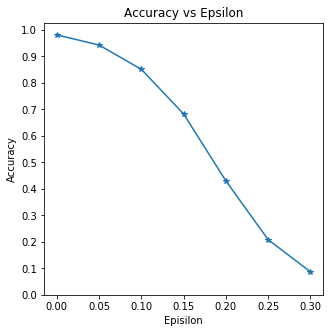

In [24]:
# Accuracy vs Epsilon graph

plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Episilon")
plt.ylabel("Accuracy")
plt.show()


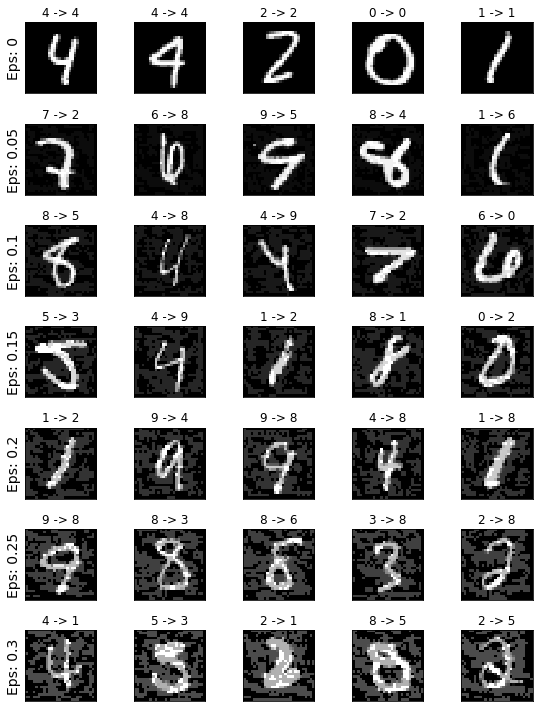

In [26]:
# plot several examples of adversarial samples at each epsilon

cnt = 0
plt.figure(figsize=(8, 10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons), len(examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()